In [1]:
# Common imports

import pandas as pd
import numpy as np
import os 
import sys
import math
import utm
import time

import json
import geopandas as gpd
import fiona

from numba import jit

from shapely.geometry import shape, mapping

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.plotting import ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral3

from bokeh.layouts import gridplot

from radar_scrape import get_radar_img_urls, request_img_files
from get_station_data import get_daily_runoff

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

output_notebook()


Loading BokehJS ...

In [2]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
DB_DIR = os.path.join(BASE_DIR, 'code/hydat_db')
PROJECT_DIR = os.path.abspath('')
RADAR_IMG_DIR = os.path.join(PROJECT_DIR, 'sorted_radar_images')
CROPPED_IMG_DIR = os.path.join(PROJECT_DIR, 'data/masked_img')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'data/AD_results')

In [3]:
stations_df = pd.read_csv(DB_DIR + '/WSC_Stations_Master.csv')

# list the stations whose catchments fall off the edge of the map
incomplete_stns = pd.read_csv(os.path.join(PROJECT_DIR,'data/incomplete_sites.txt')).columns.values
masked_stns = os.listdir(CROPPED_IMG_DIR)


In [4]:
# retrieve the results dataframe for the specified site
results_folders = os.listdir(RESULTS_DIR)

results_dict = {}
# create a dictionary of results from all AD searches
for f in results_folders:
    folder_path = os.path.join(RESULTS_DIR, f)
    all_sites = [e.split('_')[0] for e in os.listdir(folder_path)]
    for site in all_sites:
        if site in results_dict.keys():
            old_results = results_dict[site]
            new_results = pd.read_csv(os.path.join(folder_path, site + '_results.csv'))
            
            results_dict[site] = pd.concat([old_results, new_results], sort=True)
        else:          
            this_result = pd.read_csv(os.path.join(folder_path, site + '_results.csv'))
            best_result = this_result.sort_values('len_results', ascending=False).iloc[0, :]
            results_dict[site] = best_result


In [5]:
from retrieve_events import run_AD_from_results, initialize_wsc_station_info_dataframe

def get_all_event_pairs(best_events):
    event_pairs = []
    for i in np.arange(0, len(best_events) - 1, 2):
        # parse a single event pair
        this_event = best_events.iloc[i:i+2]
        date_pair = [e.astype(str).replace('T', ' ').split('.')[0].split(' ')[0] for e in this_event.index.values]
        this_start = pd.to_datetime(this_event.index.values[0])
        this_month = this_start.month
        if (this_month > 5) & (this_month <= 11) & (this_start > pd.to_datetime('2007-01-01')):
            event_pairs.append(date_pair)
    return event_pairs

stn_df = initialize_wsc_station_info_dataframe()

Using TensorFlow backend.


In [6]:
stations = os.listdir(CROPPED_IMG_DIR)

# iterate through the files and format
# the filenames as timestamps
def convert_str_to_datetime(s):
    s = s.values[0]
    return pd.to_datetime(s[:4] + '-' + s[4:6] + '-' + s[6:8] + ' ' + s[8:10] + ':' + s[10:12] )



In [152]:
def construct_event_series(event, all_filenames, stn):
    event_timerange = pd.date_range(pd.to_datetime(event[0]), pd.to_datetime(event[1]), freq='1H')
    event_img_strings = [e.strftime('%Y%m%d%H%M') for e in event_timerange]
    all_img_strings = [e for e in all_filenames if e in event_img_strings]
    all_img_strings = sorted(all_img_strings)
    return all_img_strings

def construct_event_pairs(best_events):
    event_pairs = []
    for i in np.arange(0, len(best_events) - 1, 2):
        # parse a single event pair
        this_event = best_events.iloc[i:i+2]
        date_pair = [e.astype(str).replace('T', ' ').split('.')[0].split(' ')[0] for e in this_event.index.values]
        this_start = pd.to_datetime(this_event.index.values[0])
        this_month = this_start.month
        if (this_month > 5) & (this_month <= 11) & (this_start > pd.to_datetime('2007-01-01')):
            event_pairs.append(date_pair)
    return event_pairs


In [154]:
event_dict = {}
n = 0
for stn in masked_stns:
    all_filenames = [e.split('_')[0] for e in os.listdir(os.path.join(CROPPED_IMG_DIR, stn))]
    t0 = time.time()
    best_events, test_flow_df, closest_radar_stn = run_AD_from_results(stn)
    event_pairs = construct_event_pairs(best_events)
    i = 0
    event_dict[stn] = {}
    for event in event_pairs:
        img_strings = construct_event_series(event, all_filenames, stn)
        event_dict[stn][i] = img_strings
        i += 1
    t1 = time.time()
    n += 1
    print('{}/{}: {} completed in {:.2f}s with {} events.'.format(n, len(masked_stns), stn, t1-t0, len(best_events)))

1/100: 05BL014 completed in 2.07s with 20 events.
2/100: 05DB002 completed in 2.09s with 22 events.
3/100: 05CE012 completed in 1.70s with 18 events.
4/100: 08NN019 completed in 1.85s with 10 events.
5/100: 08NE077 completed in 2.01s with 10 events.
6/100: 08LF099 completed in 2.62s with 20 events.
7/100: 05BL022 completed in 3.05s with 20 events.
8/100: 05CG006 completed in 1.83s with 18 events.
9/100: 08MH029 completed in 2.18s with 22 events.
10/100: 08NL071 completed in 2.92s with 12 events.
11/100: 08NN028 completed in 1.99s with 6 events.
12/100: 08GA072 completed in 2.53s with 16 events.
13/100: 08MH006 completed in 4.06s with 12 events.
14/100: 08MH155 completed in 4.15s with 8 events.
15/100: 05AC030 completed in 1.78s with 4 events.
16/100: 08NN023 completed in 2.19s with 10 events.
17/100: 05DB005 completed in 2.32s with 10 events.
18/100: 08NJ026 completed in 2.84s with 8 events.
19/100: 08NK018 completed in 2.25s with 22 events.
20/100: 08NE008 completed in 2.00s with 6 ev

In [155]:
# first, create a dictionary for mapping radar precip colors to mm/hr rates
cbar_path = os.path.join(PROJECT_DIR, 'img')
radar_cmap_img = Image.open(os.path.join(cbar_path, 'colorbar.png')).convert('RGB')
cmap_array = np.asarray(radar_cmap_img).astype(np.uint8)  
print('dim of cmap array = ', cmap_array.shape)
c_width, c_height = 20, 14

colour_map_dict = {}
intensities = [0.1, 1., 2., 4., 8., 12., 16., 24., 36., 50., 75., 100., 150., 200.][::-1]
for n in range(14):
    this_color = cmap_array[n * 14:n * 14 + 14, :][0,0,:]
    colour_map_dict[str(list(this_color))] = float(intensities[n])

# add an entry for zero or null
colour_map_dict[str(list([150, 150, 150]))] = 0.
colour_map_dict[str(list([0, 0, 0]))] = 0.



dim of cmap array =  (196, 20, 3)


In [156]:
for stn in masked_stns:
    folder_path = os.path.join(CROPPED_IMG_DIR, stn)
    if len(os.listdir(folder_path)) == 0:
#         print('empty: ', stn)
        os.rmdir(folder_path)
    
print(len(os.listdir(CROPPED_IMG_DIR)))

100


In [240]:
def retrieve_image(datetime_string, stn):
    folder_path = os.path.join(CROPPED_IMG_DIR, stn)
    cropped_radar_img = Image.open(os.path.join(folder_path, str(datetime_string) + '_crp.gif')).convert('RGB')
    return np.asarray(cropped_radar_img).astype(np.uint8)

def convert_pixel_color_to_precip_volume(row, stn):
    datetime_string = row['time_string']
    duration = row['dt']
    img_array = retrieve_image(datetime_string, stn)
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    vol_array = np.zeros((rows, cols, 1))
    for r in range(rows):
        for c in range(cols):
            map_color = str(list(img_array[r, c]))
            if map_color in list(colour_map_dict.keys()):
                # convert mm/h to m^3
                total_vol = colour_map_dict[map_color] * duration * 1000**2 / 1000
                vol_array[r, c] = total_vol
            else:
                vol_array[r, c] = np.nan
    return vol_array.flatten().sum()


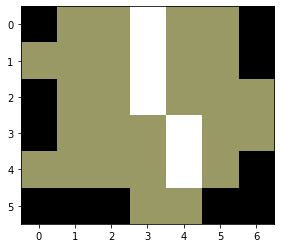

In [241]:
tstn = '08HA070'
foo = retrieve_image('201008050000', tstn)
# print(foo.shape)
plt.imshow(foo)

### New Game -- Create 2d histogram plots to show where rain falls

In [242]:
def get_sample_img(stn):
    """
    I think what I'm trying to do here is find an image that's 
    free from the colouration of precipitation.  The 'sample image'
    in this case is one which has no cell that is coloured 
    with one of the 14 colours reserved for precipitation.
    """
    events = event_dict[stn]
    precip_in_frame = False
    map_colors = [e for e in list(colour_map_dict.keys()) if e != '[0, 0, 0]']
    min_paint = 1E12
    date = None
    for e in events:
        for e_img in events[e]:
            img_array = retrieve_image(e_img, stn)
            rows = img_array.shape[0]
            cols = img_array.shape[1]
            n_colors = 0
            for r in range(rows):
                for c in range(cols):
                    map_color = str(list(img_array[r, c]))
                    if map_color in map_colors:
                        precip_in_frame = True
                        n_colors += 1
                    elif map_color == '[0, 0, 0]':
                        img_array[r, c] = np.asarray([0, 0, 0])
            if n_colors < min_paint:
                min_paint = n_colors
                best_img_event = e_img

            if precip_in_frame == False:
                return Image.fromarray(img_array, 'RGB')

    return Image.fromarray(retrieve_image(best_img_event, stn))    

In [243]:

def convert_pixel_color_to_precip_count(row, stn):
    datetime_string = row['time_string']
    duration = row['dt']
    if np.isnan(row['dt']):
        duration = 1
    img_array = retrieve_image(datetime_string, stn)
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    count = np.zeros((rows, cols))
    precip_colors = [e for e in list(colour_map_dict.keys()) if e != '[0, 0, 0]']

    for r in range(rows):
        for c in range(cols):
            map_color = str(list(img_array[r, c]))
            if map_color in precip_colors:
                # convert mm/h to m^3
                weighted_count = float(colour_map_dict[map_color]) * duration
                count[r, c] = weighted_count 
            else:
                black = np.zeros(3)
                white = np.empty(3)
                white.fill(254)
                road_color = np.empty(3)
                road_color.fill(31)
                if np.array_equal(map_color, black):
                    count[r, c] = np.nan
                elif np.array_equal(map_color, white):
                    count[r, c] = np.nan
                elif np.array_equal(map_color, road_color):
                    count[r, c] = np.nan
#                 count[r, c] = 0
#             elif map_color != '[0, 0, 0]':
#                 count[r, c] = 0
#             else:
#                 count[r, c] = 0
    return count 

def construct_precip_histogram(stn):    
    initialized = False
    
    event_pairs = event_dict[stn]

    n_initial_size = 0
    n_after_change = 0
    
    for e in event_pairs:
        all_img_strings = event_pairs[e]
        if len(all_img_strings) > 1:
            event_df = pd.DataFrame()
            event_df['time_string'] = all_img_strings
            event_df['datetime'] = event_df.apply(lambda x: convert_str_to_datetime(x), axis=1)
            event_df['dt'] = event_df['datetime'].diff(-1).astype('timedelta64[h]') * -1
            for index, row in event_df.iterrows():

                if initialized == False:
                    count_array = convert_pixel_color_to_precip_count(row, stn)
                    initialized = True
                    inital_array_shape = count_array.shape
                    n_after_change += 1
    #                 print('initial shape of count array = ', count_array.shape)


                else:
                    n_initial_size += 1
                    new_count = convert_pixel_color_to_precip_count(row, stn)
                    if new_count.shape != inital_array_shape:
    #                     print('{} changes image shape on {}'.format(stn, row))
                        break
                    count_array = np.add(count_array, new_count)
    
#     print(np.std(count_array.flatten()))
    nanlimit = np.nanpercentile(np.where(np.isclose(count_array, 0), np.nan, count_array), 95)
#     print(nanlimit)
    threshold_indices = count_array > nanlimit
    count_array[threshold_indices] = nanlimit
#     count_array = np.clip(count_array, a_min=0, a_max = nanstd)

    return count_array

In [244]:
from sklearn.preprocessing import normalize

def colorize_precip_frequency(data):
    recolored_matrix = np.zeros((data.shape[0], data.shape[1], 4))
    rows = data.shape[0]
    cols = data.shape[1]
    colour_map = plt.cm.viridis[::-1]
    for r in range(rows):
        for c in range(cols):
            recolored_matrix[r, c] = colour_map(data[r, c])
    return Image.fromarray(recolored_matrix, 'RGB')


In [245]:
@jit
def reset_bg_colors(base_img_array, new_img):
    rows = base_img_array.shape[0]
    cols = base_img_array.shape[1]
    for r in range(rows):
            for c in range(cols):
                base_color = base_img_array[r, c]
                black = np.zeros(3)
                white = np.empty(3)
                white.fill(254)
                road_color = np.empty(3)
                road_color.fill(31)
                if np.array_equal(base_color, black):
                    new_img[r, c] = np.nan
                elif np.array_equal(base_color, white):
                    new_img[r, c] = np.nan
                elif np.array_equal(base_color, road_color):
                    new_img[r, c] = np.nan
    return new_img
    

In [246]:
masked_stns_filtered = [e for e in masked_stns if len(event_dict[e].keys()) > 0]

Text(0.5, 1.0, '08NJ160: 181.0km2')

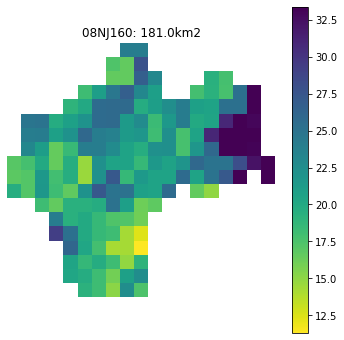

In [247]:
test_stn = masked_stns_filtered[91]
count_array = construct_precip_histogram(test_stn)

fig, ax = plt.subplots(figsize=(6, 6))

base_image = get_sample_img(test_stn)
stn_dat = stations_df[stations_df['Station Number'] == test_stn]
stn_da = stn_dat['Gross Drainage Area (km2)']

base_img_array = np.array(base_image, dtype=np.int_)

remapped_colors_array = reset_bg_colors(base_img_array, count_array)

# ax.imshow(remapped_colors_array, cmap='viridis_r', interpolation='nearest', alpha=1)
cs = ax.imshow(remapped_colors_array, cmap='viridis_r', interpolation='nearest', alpha=1)
cbar = fig.colorbar(cs)
ax.axis('off')
ax.set_title(test_stn + ': {:.1f}km2'.format(stn_da.values[0]))

/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([0.00491836, 0.01967342, 0.0663978 , 0.09344875, 0.09836711,
        0.05164273, 0.06393862, 0.01229589, 0.00737753, 0.03442849]),
 array([11.3 , 13.51, 15.72, 17.93, 20.14, 22.35, 24.56, 26.77, 28.98,
        31.19, 33.4 ]),
 <a list of 10 Patch objects>)

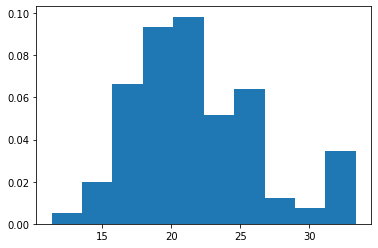

In [248]:
plt.hist(count_array.flatten(), density=True)

In [264]:
bad_stns = [
#     '08NE006', '08LE024', '05AB005', '05BL027', '08MF068', '08MF065', 
    '05BL022', '08LE027', '05AA909',
    '05CB004', '08HA001', '05FC002', '08NL069', '08MH103', '08NL070', '08HB002',
    '08MH016', '08MG026', '08LG068', '08MH056', '08ME027', '08MF062', '08HB048',
    '08HB032', '08LE077', '08HA016', '08LF100', '08NN028', '08GA072', '05BJ004',
    '08LB069', '08KA009', '08HB004', '05BL023', '08HB014', '05BG006', '08NM171',
    '08NL050', '05CA004', '08NK018', '05BL019', '08MH006', '08KB006', '08LF099'
]
print(sorted(bad_stns))

['05AA909', '05BG006', '05BJ004', '05BL019', '05BL022', '05BL023', '05CA004', '05CB004', '05FC002', '08GA072', '08HA001', '08HA016', '08HB002', '08HB004', '08HB014', '08HB032', '08HB048', '08KA009', '08KB006', '08LB069', '08LE027', '08LE077', '08LF099', '08LF100', '08LG068', '08ME027', '08MF062', '08MG026', '08MH006', '08MH016', '08MH056', '08MH103', '08NK018', '08NL050', '08NL069', '08NL070', '08NM171', '08NN028']


In [265]:
masked_stns_filtered = [e for e in masked_stns_filtered if len(event_dict[e].keys()) > 0]
masked_stns_filtered = [e for e in masked_stns_filtered if e not in bad_stns]

station_data = stations_df[stations_df['Station Number'].isin(masked_stns_filtered)]
station_data = station_data.sort_values('Gross Drainage Area (km2)', ascending=False)

# print(station_data[['Station Number', 'Gross Drainage Area (km2)']].head())
print(len(masked_stns_filtered))

81


In [266]:
print(station_data[station_data['Station Number'] == '05CE006'])

     Station Number                         Station Name Province  Status  \
3464        05CE006  ROSEBUD RIVER BELOW CARSTAIRS CREEK       AB  Active   

      Latitude  Longitude  Year From  Year To  Gross Drainage Area (km2)  \
3464  51.41583 -113.72778       1957     2018                      753.0   

      Effective Drainage Area (km2)  ...       Data Type Operation Schedule  \
3464                          642.0  ...  Flow and Level           Seasonal   

     Sediment RHBN Real-Time     Datum Name Publishing Office  \
3464        Y    N         Y  ASSUMED DATUM           CALGARY   

     Operating Agency Contributed   Elevation  
3464              NaN           N  930.027405  

[1 rows x 21 columns]


In [267]:
# construct precipitation histograms
# spatial_precip_dict = {}
# for stn in station_data['Station Number'].values:
#     spatial_precip_dict[stn] = construct_precip_histogram(stn)

In [268]:
for i in range(1,40):
    if 82 % i == 0:
        print(i)

1
2


08ND012 (0/81) process time: 19.63 s
05DB002 (1/81) process time: 0.01 s
05CA002 (2/81) process time: 11.90 s
05CC013 (3/81) process time: 7.76 s
05BM014 (4/81) process time: 0.00 s
05CE006 (5/81) process time: 10.57 s
05BL014 (6/81) process time: 8.04 s
08NH130 (7/81) process time: 0.00 s
08HA010 (8/81) process time: 0.00 s
05CD007 (9/81) process time: 0.00 s
05BL013 (10/81) process time: 0.00 s
05CE012 (11/81) process time: 0.00 s
05CA012 (12/81) process time: 3.44 s
05CC011 (13/81) process time: 0.00 s
05CB002 (14/81) process time: 0.00 s
08NH005 (15/81) process time: 0.00 s
08JE004 (16/81) process time: 0.00 s
08NF001 (17/81) process time: 1.28 s
08KA001 (18/81) process time: 0.00 s
08MG001 (19/81) process time: 0.00 s
05CC008 (20/81) process time: 1.66 s
05AC030 (21/81) process time: 0.00 s
08NE039 (22/81) process time: 0.00 s
08LG048 (23/81) process time: 0.00 s
07EE009 (24/81) process time: 0.38 s
08NE110 (25/81) process time: 0.00 s
08MH147 (26/81) process time: 0.00 s
08GA075 

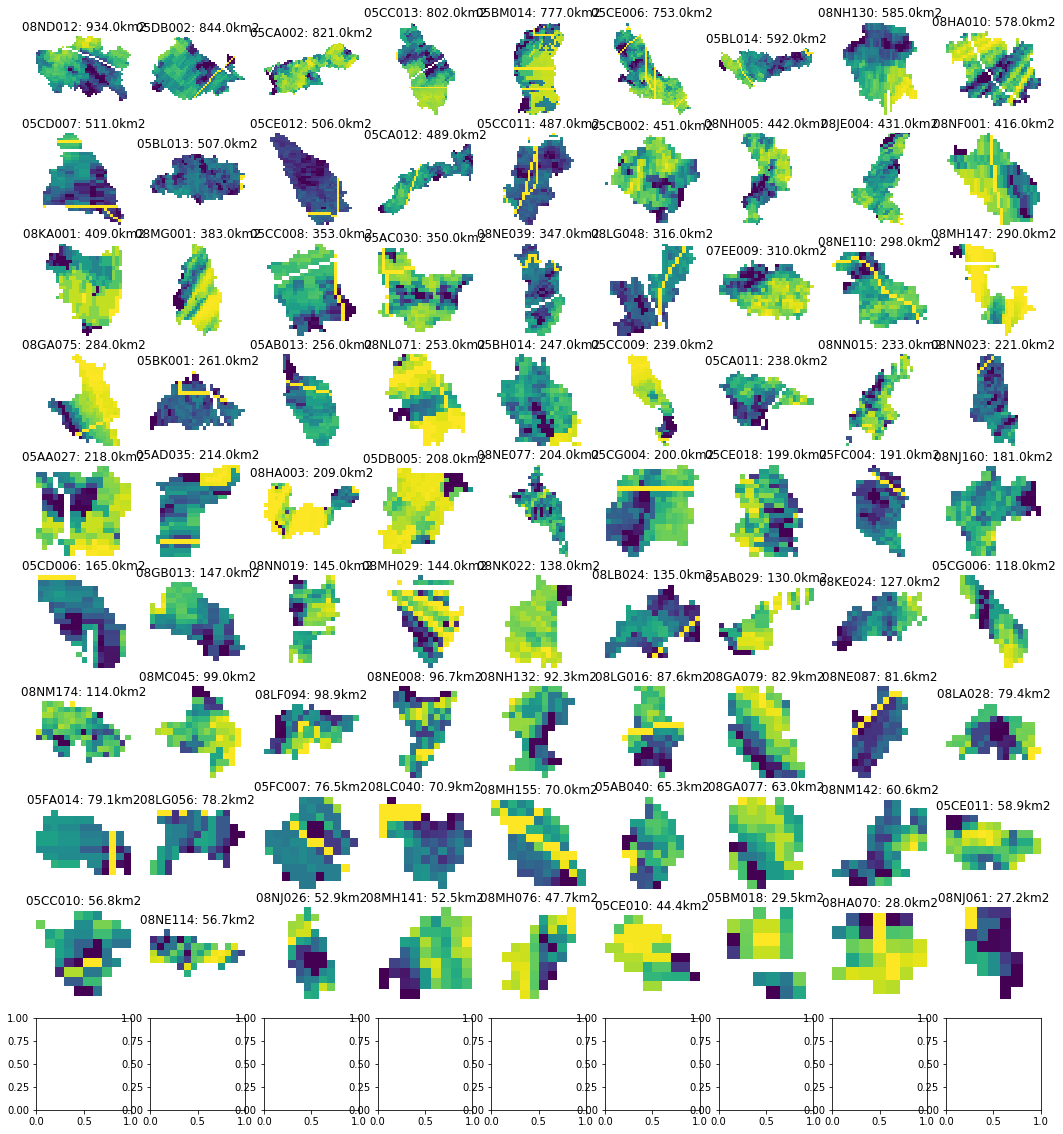

In [269]:
colored_maps = []
rows = 9
cols = 9
n = 0
r, c = 0, 0

fig, ax = plt.subplots(rows, cols, figsize=(18, 20))

for stn in station_data['Station Number'].values:
    t0 = time.time()
    base_image = get_sample_img(stn)   
    stn_dat = stations_df[stations_df['Station Number'] == stn]
    stn_da = stn_dat['Gross Drainage Area (km2)']
#     ax[r, c].imshow(base_image, alpha=0.5)
    
    colorized_img_array = spatial_precip_dict[stn]
    t1 = time.time()
    print('{} ({}/{}) process time: {:.2f} s'.format(stn, n, len(masked_stns_filtered),t1-t0))
    base_img_array = np.array(base_image, dtype=np.int_)
    remapped_colors_array = reset_bg_colors(base_img_array, colorized_img_array)

    ax[r, c].imshow(remapped_colors_array, cmap='viridis_r', interpolation='nearest', alpha=1)

    ax[r, c].axis('off')
    ax[r, c].set_title(stn + ': {:.1f}km2'.format(stn_da.values[0]))
    c += 1
    if c == cols:
        c = 0
        r += 1

    n += 1

# plt.axis('off')

In [ ]:
# fig.savefig('spatial_precip_grid_plot_names.png', dpi=200, pad_inches=0, bbox_inches=0)

## Reconstruct Hydrograph

In [235]:
def calculate_precip_volume(row, stn):
    datetime_string = row['time_string']
    duration = row['dt']
    if np.isnan(row['dt']):
        duration = 1
    img_array = retrieve_image(datetime_string, stn)
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    count = np.zeros((rows, cols))
    precip_colors = [e for e in list(colour_map_dict.keys()) if e != '[0, 0, 0]']

    for r in range(rows):
        for c in range(cols):
            map_color = str(list(img_array[r, c]))
            if map_color in precip_colors:
                # convert mm/h to m^3
                # convert the volume fallen on each cell to flow rate in m^3/s
                weighted_count = float(colour_map_dict[map_color]) * duration * 1000
                count[r, c] = weighted_count 
            else:
                black = np.zeros(3)
                white = np.empty(3)
                white.fill(254)
                road_color = np.empty(3)
                road_color.fill(31)
                if np.array_equal(map_color, black):
                    count[r, c] = np.nan
                elif np.array_equal(map_color, white):
                    count[r, c] = np.nan
                elif np.array_equal(map_color, road_color):
                    count[r, c] = np.nan
    return np.sum(count) 



In [273]:
def arrange_plots_into_grid(stn_plots):
    stn = stn_plots[0]
    plots = stn_plots[1]
    stn_info = stations_df[stations_df['Station Number'] == stn]
    stn_DA = stn_info['Gross Drainage Area (km2)'].values[0]
    print('Station: {} ({} km^2)'.format(stn, stn_DA))
    n_cols = 5
    n_rows = int(np.ceil(len(plots) / n_cols))

    g = []
    for i in range(0, len(plots), n_cols):
        g += [plots[i:i+n_cols]]
    grid = gridplot(g, plot_width=150, plot_height=150)
    return grid


def construct_unit_hydrograph(stn, event_timestamps):
    event_df = pd.DataFrame()
    event_df['time_string'] = event_timestamps
    event_df['datetime'] = event_df.apply(lambda x: convert_str_to_datetime(x), axis=1)
    event_df['dt'] = event_df['datetime'].diff(-1).astype('timedelta64[h]') * -1
    event_df['precip_vol'] = event_df.apply(lambda row: calculate_precip_volume(row, stn), axis=1)
#     print(event_df)
    return event_df

def concatenate_precip_and_flow(stn, event):
    precip_df = construct_unit_hydrograph(stn, event)
    precip_df.set_index('datetime', inplace=True)
    precip_df = precip_df.resample('1D').sum()
    
    precip_df['cumsum_m3'] = precip_df['precip_vol'].cumsum()
    precip_df['precip_rate_cms'] = precip_df['precip_vol'] / 24 / 3600
    
    ## find the concurrent flow record
    flow_df = get_daily_runoff(stn)
    flow_df.rename(columns={'DAILY_FLOW': 'flow_cms'}, inplace=True)
    flow_df['Year'] = flow_df.index.year
    flow_df['Month'] = flow_df.index.month
    
    df = pd.concat([precip_df, flow_df[['flow_cms']]], join='inner', axis=1)
    df = df[['precip_rate_cms', 'flow_cms']]
    event_duration = (df.index[-1] - df.index[0]).days

    if event_duration >= 2:
        return df
    else:
        return None


def create_plot_grid(stn):
    
    n_events = len(event_dict[stn])
    print(n_events)
    
    plots = []    
    for event in event_dict[stn]:
        # parse a single event pair
        this_event_df = concatenate_precip_and_flow(stn, event_dict[stn][event])
        if this_event_df is not None:
            s1 = figure(background_fill_color="#fafafa", x_axis_type='datetime')  
            s1.xaxis.major_label_orientation = math.pi/2
            s1.line(this_event_df.index, this_event_df['precip_rate_cms'], color='green')
            s1.line(this_event_df.index, this_event_df['flow_cms'], color='blue')
            plots.append(s1)    
    return plots


In [ ]:
grids = []
n = 0
# stations_1 = stations[:5]
for stn in ['05DB002']:
    stn_info = stations_df[stations_df['Station Number'] == stn]
    stn_DA = stn_info['Gross Drainage Area (km2)'].values[0]
    print(stn)
    print('{} ({}/{}): {} km^2'.format(stn, n, len(stations), stn_DA))
    grids.append((stn, create_plot_grid(stn)))
    n += 1
    
show(arrange_plots_into_grid(grids[0]))

05DB002
05DB002 (0/100): 844.0 km^2
11
